# Table of Contents

[Libaries](#Libraries) <br>
[Variables](#Variables)
1. [Data Import & Manipulation](#1.-Data-Import-&-Manipulation) 
    1. [Fuel Output & Demand Data](#A.-Fuel-Output-&-Demand-Data)
    2. [HOEP Data](#B.-HOEP-Data)
    3. [NG Production & Demand Data](#C.-NG-Production-&-Demand-Data)
    4. [Transportation Demand Data](#D.-Transportation-Demand-Data)
    5. [Industry Demand Data](#E.-Industry-Demand-Data)
    6. [Emission Factor Calculation](#F.-Emission-Factor-Calculation)
    7. [Input-Data-to-MILP](#G.-Input-Data-to-MILP)
2. [Mixed Integer Linear Programming](#2.-Mixed-Integer-Linear-Programming)
    1. [RNG MILP](#A.-RNG-MILP)
    2. [HENG MILP](#B.-HENG-MILP)
    3. [Transportation MILP](#C.-Transportation-MILP)
    4. [Industry MILP](#D.-Industry-MILP)
    5. [Combined MILP](#E.-Combined-MILP)
3. [Results](#3.-Results)
    1. [RNG Result](#A.-RNG-Result)
    2. [HENG Result](#B.-HENG-Result)
    3. [Transportation Result](#C.-Transportation-Result)
    4. [Industry Result](#D.-Industry-Result)
    5. [Combined Result](#E.-Combined-Result)


# Libraries

In [1]:
import pandas as pd

# Variables 

Import the csv file with variables 

In [2]:
raw=pd.read_csv('Variables.csv')
raw2=raw.dropna(axis='columns',how='all')
var=raw2.dropna(axis='rows',how='all')
var.set_index("variable_name",inplace=True)

In [3]:
var

,value,unit,source,comment
variable_name,,,,
MW_H2,1.008000e+00,kg/kmol,internet,NaN
density_H2,8.990000e-02,kg/m^3,ushnik,NaN
electrolyzer_eff,7.667000e-01,dimensionless,eqtn 3.1,NaN
E_hhv_h2,3.550000e+00,kWh/m^3 H2,eqtn 3.1,NaN
E_rated_h2,4.630000e+00,kWh/m^3 H2,eqtn 3.1,NaN
min_E_cap,0.000000e+00,kWh,eqtn 3.3,NaN
max_E_cap,1.000000e+03,kWh,eqtn 3.3,NaN
water_cons_rate,4.000000e-01,L H2O/m^3 H2,eqtn 3.4,NaN
meth_reactor_eff,7.700000e-01,dimensionless,eqtn 3.13,NaN


# 1. Data Import & Manipuation

## A. Fuel Output & Demand Data

Import the fuel output data by sources (i.e. nuclear, gas, hydro)

In [4]:
fuel_output = pd.read_csv('on_fuel_source_output_2017.csv', keep_default_na=False, na_values=[""])

Impor the fuel demand in Onatrio data 

In [5]:
fuel_demand = pd.read_csv('on_demand_2017.csv', keep_default_na=False, na_values=[""])

Subtract 1 hour from the hour because we want 0 to 23 hr 

In [6]:
fuel_output['Hour'] = fuel_output['Hour'] - 1

In [7]:
fuel_output.head()

,Date,Hour,Fuel,Output
0,2017-01-01,0,NUCLEAR,11592
1,2017-01-01,0,GAS,234
2,2017-01-01,0,HYDRO,2455
3,2017-01-01,0,WIND,2433
4,2017-01-01,0,SOLAR,0


In [8]:
fuel_demand['Hour'] = fuel_demand['Hour'] -1

In [9]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create Datetime columns in both dataframes

In [10]:
fuel_output['Datetime'] = pd.to_datetime(fuel_output['Date']) + pd.to_timedelta(fuel_output['Hour'], unit='h')

In [11]:
fuel_output.head()

,Date,Hour,Fuel,Output,Datetime
0,2017-01-01,0,NUCLEAR,11592,2017-01-01
1,2017-01-01,0,GAS,234,2017-01-01
2,2017-01-01,0,HYDRO,2455,2017-01-01
3,2017-01-01,0,WIND,2433,2017-01-01
4,2017-01-01,0,SOLAR,0,2017-01-01


In [12]:
fuel_demand['Datetime'] = pd.to_datetime(fuel_demand['Date']) + pd.to_timedelta(fuel_demand['Hour'], unit='h')

In [13]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff,Datetime
0,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268",2017-01-01 00:00:00
1,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673",2017-01-01 01:00:00
2,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974",2017-01-01 02:00:00
3,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186",2017-01-01 03:00:00
4,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227",2017-01-01 04:00:00


Groupby the fuel data dataframe by Datetime

In [14]:
fuel_output_total = pd.DataFrame(fuel_output.groupby('Datetime')['Output'].sum())
fuel_output_total.columns = ['fuel_total']

In [15]:
fuel_output_total.head()

,fuel_total
Datetime,
2017-01-01 00:00:00,16715
2017-01-01 01:00:00,16344
2017-01-01 02:00:00,15942
2017-01-01 03:00:00,15727
2017-01-01 04:00:00,15653


Set index of the demand dataframe using Datetime

In [16]:
fuel_demand.set_index('Datetime',inplace=True)

In [17]:
fuel_demand.head()

,Date,Hour,Ontario Demand,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Zone Total,Diff
Datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,13522,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,268"
2017-01-01 01:00:00,2017-01-01,1,13117,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,673"
2017-01-01 02:00:00,2017-01-01,2,12816,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"2,974"
2017-01-01 03:00:00,2017-01-01,3,12605,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,186"
2017-01-01 04:00:00,2017-01-01,4,12563,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"3,227"


Create SBG data by joining the two data demand and output data and taking the difference between the two 

In [18]:
SBG = pd.merge(fuel_output_total[['fuel_total']],fuel_demand[['Ontario Demand']], how='inner',left_index=True, right_index=True)

In [19]:
SBG.head()

,fuel_total,Ontario Demand
Datetime,,
2017-01-01 00:00:00,16715,13522
2017-01-01 01:00:00,16344,13117
2017-01-01 02:00:00,15942,12816
2017-01-01 03:00:00,15727,12605
2017-01-01 04:00:00,15653,12563


In [20]:
SBG['Difference'] = SBG['fuel_total'] - SBG['Ontario Demand']

In [21]:
SBG.head()

,fuel_total,Ontario Demand,Difference
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193
2017-01-01 01:00:00,16344,13117,3227
2017-01-01 02:00:00,15942,12816,3126
2017-01-01 03:00:00,15727,12605,3122
2017-01-01 04:00:00,15653,12563,3090


Check if there's any cell with difference less than 0

In [22]:
SBG[SBG['Difference']<0].count()

fuel_total        697
Ontario Demand    697
Difference        697
dtype: int64

Assign negative numbers with 0's 

In [23]:
SBG.loc[SBG['Difference']<=0,'Difference'] = 0

In [24]:
SBG[SBG['Difference']<0].count()

fuel_total        0
Ontario Demand    0
Difference        0
dtype: int64

Convert SBG from MWh to kWh

In [25]:
SBG['Difference'] = SBG['Difference']*1000

Change the column names of the SBG dataframe 

In [26]:
SBG.columns = ['fuel_output','fuel_demand','SBG(kWh)']

In [27]:
SBG.head()

,fuel_output,fuel_demand,SBG(kWh)
Datetime,,,
2017-01-01 00:00:00,16715,13522,3193000
2017-01-01 01:00:00,16344,13117,3227000
2017-01-01 02:00:00,15942,12816,3126000
2017-01-01 03:00:00,15727,12605,3122000
2017-01-01 04:00:00,15653,12563,3090000


## B. HOEP Data

Import the HOEP data <br>
Note: HOEP values are reported as $/MWh

In [28]:
hoep_data = pd.read_csv('HOEP_2017.csv', keep_default_na=False, na_values=[""])

In [29]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
0,2017-01-01,1,0.0,5.94,0.0,0.0,NaN,NaN,NaN
1,2017-01-01,2,0.0,0.00,2.2,0.0,NaN,NaN,NaN
2,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN
3,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN
4,2017-01-01,5,0.0,0.00,0.0,0.0,NaN,NaN,NaN


Change the hour to hour-1

In [30]:
hoep_data['Hour'] = hoep_data['Hour'] -1

Create datetime column

In [31]:
hoep_data['Datetime'] = pd.to_datetime(hoep_data['Date']) + pd.to_timedelta(hoep_data['Hour'], unit='h')

In [32]:
hoep_data.head()

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min,Datetime
0,2017-01-01,0,0.0,5.94,0.0,0.0,NaN,NaN,NaN,2017-01-01 00:00:00
1,2017-01-01,1,0.0,0.00,2.2,0.0,NaN,NaN,NaN,2017-01-01 01:00:00
2,2017-01-01,2,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 02:00:00
3,2017-01-01,3,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 03:00:00
4,2017-01-01,4,0.0,0.00,0.0,0.0,NaN,NaN,NaN,2017-01-01 04:00:00


Set the index of the hoep data using the datetime

In [33]:
hoep_data.set_index('Datetime',inplace=True)

In [34]:
hoep_data.head(10)

,Date,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
Datetime,,,,,,,,,
2017-01-01 00:00:00,2017-01-01,0,0.00,5.94,0.00,0.00,NaN,NaN,NaN
2017-01-01 01:00:00,2017-01-01,1,0.00,0.00,2.20,0.00,NaN,NaN,NaN
2017-01-01 02:00:00,2017-01-01,2,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 03:00:00,2017-01-01,3,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 04:00:00,2017-01-01,4,0.00,0.00,0.00,0.00,NaN,NaN,NaN
2017-01-01 05:00:00,2017-01-01,5,0.00,0.01,0.00,1.99,NaN,NaN,NaN
2017-01-01 06:00:00,2017-01-01,6,0.00,5.94,6.04,6.02,NaN,NaN,NaN
2017-01-01 07:00:00,2017-01-01,7,1.71,6.74,8.42,6.74,NaN,NaN,NaN
2017-01-01 08:00:00,2017-01-01,8,0.00,5.74,5.70,5.84,NaN,NaN,NaN


HOEP data is dollar/Mwh so need to convert to dollar/kWh

In [35]:
hoep_data['HOEP']= hoep_data['HOEP']/1000

Merge the SBG data and HOEP data

In [36]:
input_df = pd.merge(SBG[['SBG(kWh)']],hoep_data[['HOEP']], how='inner',left_index=True, right_index=True)

In [37]:
input_df.head(10)

,SBG(kWh),HOEP
Datetime,,
2017-01-01 00:00:00,3193000,0.00000
2017-01-01 01:00:00,3227000,0.00000
2017-01-01 02:00:00,3126000,0.00000
2017-01-01 03:00:00,3122000,0.00000
2017-01-01 04:00:00,3090000,0.00000
2017-01-01 05:00:00,2898000,0.00000
2017-01-01 06:00:00,2739000,0.00000
2017-01-01 07:00:00,2726000,0.00171
2017-01-01 08:00:00,2267000,0.00000


In [80]:
input_df.head(10)

,Datetime,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
0,2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311,0.000025
1,2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311,0.000025
2,2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311,0.000026
3,2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311,0.000026
4,2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311,0.000026
5,2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311,0.000026
6,2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311,0.000026
7,2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311,0.000026
8,2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311,0.000026
9,2017-01-01 09:00:00,2324000,0.00000,234021.0,166093.882091,17052.280311,0.000026


In [92]:
#creating a 0 cell column for 67% capacity factor 
input_df['SBG_67'] = 0
input_df['SBG_67'] = input_df['SBG_67'].astype(float)

#creating a 0 cell column for 80% capacity factor 
input_df['SBG_80'] = 0
input_df['SBG_80'] = input_df['SBG_80'].astype(float)

#creating a 0 cell column for 96% capacity factor 
input_df['SBG_96'] = 0
input_df['SBG_96'] = input_df['SBG_96'].astype(float)

display(input_df.head())


HOEP_lbound = -6.7 / 100 #cent/kWh*1dollar/100cents
for capacity_factor in ['SBG_67','SBG_80','SBG_96']:
    if capacity_factor == 'SBG_67':
        HOEP_ubound = 4.0 / 100 #cent/kWh*1dollar/100cents
    elif capacity_factor == 'SBG_80':
        HOEP_ubound = 31.4 / 100 #cent/kWh*1dollar/100cents
    else: #capacity_factor == 'SBG_96'
        HOEP_ubound = 182.3 / 100 #cent/kWh*1dollar/100cents
            
    for index, row in input_df.iterrows():

        curr_price = input_df.loc[index,'HOEP']
        
        #within the range of HOEP given by Suaad
        if ((curr_price >= HOEP_lbound) and (curr_price <= HOEP_ubound)):     
            input_df.loc[index,capacity_factor] = input_df.loc[index,'SBG(kWh)']
        else: #outside of that region
            pass #leave it as 0

display(input_df.head())

,Datetime,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh),SBG_67,SBG_80,SBG_96
0,2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311,0.000025,0.0,0.0,0.0
1,2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311,0.000025,0.0,0.0,0.0
2,2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311,0.000026,0.0,0.0,0.0
3,2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311,0.000026,0.0,0.0,0.0
4,2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311,0.000026,0.0,0.0,0.0


,Datetime,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh),SBG_67,SBG_80,SBG_96
0,2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311,0.000025,3193000.0,3193000.0,3193000.0
1,2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311,0.000025,3227000.0,3227000.0,3227000.0
2,2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311,0.000026,3126000.0,3126000.0,3126000.0
3,2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311,0.000026,3122000.0,3122000.0,3122000.0
4,2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311,0.000026,3090000.0,3090000.0,3090000.0


## C. NG Production & Demand Data

Import the NG hourly distribution data

In [38]:
NG_hourly_distribution = pd.read_csv('NG_hourly_distribution.csv')

In [39]:
NG_hourly_distribution.head(24)

,hour,hourly_distribution
0,1,105
1,2,100
2,3,95
3,4,95
4,5,100
5,6,110
6,7,140
7,8,145
8,9,125
9,10,120


Calculate the ratio of the distribution each hour using hourly distribution divided by the sum of the hourly distribution 

In [40]:
NG_hourly_distribution['ratio'] = NG_hourly_distribution['hourly_distribution']/sum(NG_hourly_distribution['hourly_distribution'])

Substract 1 from the hour

In [41]:
NG_hourly_distribution['hour'] = NG_hourly_distribution['hour']-1

In [42]:
NG_hourly_distribution.head()

,hour,hourly_distribution,ratio
0,0,105,0.033113
1,1,100,0.031536
2,2,95,0.029959
3,3,95,0.029959
4,4,100,0.031536


Import the NG monthly production data

In [43]:
NG_monthly_production = pd.read_csv('NG_monthly_production.csv')

In [44]:
NG_monthly_production.head()

,month,NG_production(e3m3/d)
0,1,6184
1,2,6165
2,3,6168
3,4,5978
4,5,6170


Create NG demand column in the input_df

In [45]:
input_df['NG_demand(m^3)'] = 0
input_df['NG_demand(m^3)'] = input_df['NG_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,0.0
2017-01-01 01:00:00,3227000,0.0,0.0
2017-01-01 02:00:00,3126000,0.0,0.0
2017-01-01 03:00:00,3122000,0.0,0.0
2017-01-01 04:00:00,3090000,0.0,0.0


NG demand calculation: hourly NG demand = ratio at that hour * production in that month

In [46]:
for index, row in input_df.iterrows():
   
    curr_hour = index.hour
    curr_month = index.month 
    ratio = NG_hourly_distribution[NG_hourly_distribution['hour']==curr_hour]['ratio'].iloc[0]
    NG_prod = NG_monthly_production[NG_monthly_production['month']==curr_month]['NG_production(e3m3/d)'].iloc[0]
  
    input_df.loc[index,'NG_demand(m^3)'] = (ratio * NG_prod).round(3)*1000
    

In [47]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3)
Datetime,,,
2017-01-01 00:00:00,3193000,0.0,204768.0
2017-01-01 01:00:00,3227000,0.0,195017.0
2017-01-01 02:00:00,3126000,0.0,185266.0
2017-01-01 03:00:00,3122000,0.0,185266.0
2017-01-01 04:00:00,3090000,0.0,195017.0


## D. Transportation Demand Data

Import the mobility demand data 

In [48]:
mobility_hourly_distribution = pd.read_csv('mobility_hourly_distribution.csv')

In [49]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,1,1.05
1,2,0.80
2,3,0.70
3,4,0.40
4,5,0.90


Change the hour to hour-1

In [50]:
mobility_hourly_distribution['hour'] = mobility_hourly_distribution['hour'] -1

In [51]:
mobility_hourly_distribution.head()

,hour,% of daily demand
0,0,1.05
1,1,0.80
2,2,0.70
3,3,0.40
4,4,0.90


In [52]:
mobility_hourly_distribution

,hour,% of daily demand
0,0,1.05
1,1,0.80
2,2,0.70
3,3,0.40
4,4,0.90
5,5,1.10
6,6,2.05
7,7,3.05
8,8,4.05
9,9,5.60


mobility monthly hour distribution = mobility hourly distribution * 264000 kg demand * 1m^3/0.0899kg H2 

In [53]:
mobility_hourly_distribution['demand(m^3)'] = mobility_hourly_distribution['% of daily demand'] / 100 * 264000 /0.0899

In [54]:
mobility_hourly_distribution.head()

,hour,% of daily demand,demand(m^3)
0,0,1.05,30834.260289
1,1,0.80,23492.769744
2,2,0.70,20556.173526
3,3,0.40,11746.384872
4,4,0.90,26429.365962


Weekly profile according to the mobility Excel workbook

In [55]:
# weekday number 6= Sunday, 0 = Monday,... 5 = Saturday 
week_profile_dict = {'weekday': [6,0,1,2,3,4,5],
         'factor': [101,94,96,100,105,108,96]}

week_profile_df = pd.DataFrame.from_dict(week_profile_dict)

week_profile_df['factor_fraction'] = week_profile_df['factor']/100
week_profile_df

,factor,weekday,factor_fraction
0,101,6,1.01
1,94,0,0.94
2,96,1,0.96
3,100,2,1.00
4,105,3,1.05
5,108,4,1.08
6,96,5,0.96


Create mobility demand column in the input data

In [56]:
input_df['mobility_demand(m^3)'] = 0
input_df['mobility_demand(m^3)'] = input_df['mobility_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,0.0


Calculate mobility demand hourly profile = weekday factor * hourly mobility demand

In [57]:
for index, row in input_df.iterrows():
    curr_weekday = index.weekday()
    curr_hour = index.hour 
    week_factor = week_profile_df[week_profile_df['weekday']==curr_weekday]['factor_fraction'].iloc[0]
    mob_demand = mobility_hourly_distribution[mobility_hourly_distribution['hour']==curr_hour]['demand(m^3)'].iloc[0]
    input_df.loc[index,'mobility_demand(m^3)'] = mob_demand * week_factor 

In [58]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3)
Datetime,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622


## E. Industry Demand Data

Total industry production capacity (MSm^3/day)

In [59]:
total_daily_production = 6.3 #MSm^3/day

Total yearly production

In [60]:
total_yearly_production = total_daily_production * 365

print(total_yearly_production)

2299.5


Industry monthly demand according to the paper = monthly demand hydrogen percetnage * total yearly production 

In [61]:
ind_demand_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'monthly_demand_hydrogen[kg]': [3.2,2.7,2.4,2.1,2,1.8,1.7,2,2.1,2.7,3,3.3]
         }
monthly_hydrogen_demand = pd.DataFrame.from_dict(ind_demand_dic)
total_hydrogen_demand = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]'].sum()
monthly_hydrogen_demand['percentage'] = monthly_hydrogen_demand['monthly_demand_hydrogen[kg]']/total_hydrogen_demand
monthly_hydrogen_demand['production_capacity[m^3/day]'] = total_yearly_production * monthly_hydrogen_demand['percentage'] * (10**6)
monthly_hydrogen_demand

,month,monthly_demand_hydrogen[kg],percentage,production_capacity[m^3/day]
0,1,3.2,0.110345,2.537379e+08
1,2,2.7,0.093103,2.140914e+08
2,3,2.4,0.082759,1.903034e+08
3,4,2.1,0.072414,1.665155e+08
4,5,2.0,0.068966,1.585862e+08
5,6,1.8,0.062069,1.427276e+08
6,7,1.7,0.058621,1.347983e+08
7,8,2.0,0.068966,1.585862e+08
8,9,2.1,0.072414,1.665155e+08
9,10,2.7,0.093103,2.140914e+08


Creating empty column in the input df for industry demand

In [62]:
input_df['industry_demand(m^3)'] = 0
input_df['industry_demand(m^3)'] = input_df['industry_demand(m^3)'].astype(float)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,0.0
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,0.0
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,0.0
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,0.0
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,0.0


number of days in each month

In [63]:
num_days_dic = {'month': [1,2,3,4,5,6,7,8,9,10,11,12],
         'number_of_days': [31,28,31,30,31,30,31,31,30,31,30,31]}
num_days_df = pd.DataFrame.from_dict(num_days_dic)
num_days_df

,month,number_of_days
0,1,31
1,2,28
2,3,31
3,4,30
4,5,31
5,6,30
6,7,31
7,8,31
8,9,30
9,10,31


Create hourly profile for industry demand = monthly production capacity / number of days in the month * 24 hours in month * 0.05 (5% demand supply criteria)

In [64]:
for index, row in input_df.iterrows():
    curr_month = index.month 
    num_days = num_days_df[num_days_df['month']==curr_month]['number_of_days'].iloc[0]
    ind_prod = monthly_hydrogen_demand[monthly_hydrogen_demand['month']==curr_month]['production_capacity[m^3/day]'].iloc[0]
    input_df.loc[index,'industry_demand(m^3)'] = ind_prod / (num_days * 24) * 0.05

In [65]:
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3)
Datetime,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311


## F. Emission Factor Calculation

Hourly average emission factor calculated using the fuel output 

In [66]:
#EMF(tonne/kWh)

emission_factor = fuel_output.copy()
emission_factor['Emission'] = 0
emission_factor['Emission'] = emission_factor['Emission'].astype(float)
emission_factor.head()


#all in kgCO2/MWh 
EMF_nuclear = 17 
EMF_gas = 622
EMF_hydro = 18
EMF_wind = 14
EMF_solar = 39
EMF_biofuel = 177


for index, row in emission_factor.iterrows():
    fuel_type = row['Fuel']
    
    if fuel_type == 'NUCLEAR':
        EMF = EMF_nuclear
    elif fuel_type == 'GAS':
        EMF = EMF_gas
    elif fuel_type == 'HYDRO':
        EMF = EMF_hydro
    elif fuel_type == 'BIOFUEL':
        EMF = EMF_biofuel
    elif fuel_type == 'SOLAR':
        EMF = EMF_solar
    else:
        EMF = EMF_wind
        
    emission_factor.loc[index,'Emission'] = EMF * emission_factor.loc[index,'Output']

emission_factor.head()

emission_factor_agg = pd.DataFrame(emission_factor.groupby('Datetime').agg({'Emission':'sum','Output':'sum'}))

emission_factor_agg['EMF(kgCO2/MWh)'] = emission_factor_agg['Emission'] / emission_factor_agg['Output'] 
emission_factor_agg['EMF(tonne/kWh)'] = emission_factor_agg['EMF(kgCO2/MWh)'] / 1000 / 1000 #unit conversion 1tonne/1000kg, 1MW/1000kW
emission_factor_agg.head()

,Emission,Output,EMF(kgCO2/MWh),EMF(tonne/kWh)
Datetime,,,,
2017-01-01 00:00:00,421041.0,16715,25.189411,0.000025
2017-01-01 01:00:00,416724.0,16344,25.497063,0.000025
2017-01-01 02:00:00,410267.0,15942,25.734977,0.000026
2017-01-01 03:00:00,408635.0,15727,25.983023,0.000026
2017-01-01 04:00:00,406922.0,15653,25.996422,0.000026


In [67]:
input_df = pd.merge(input_df,emission_factor_agg[['EMF(tonne/kWh)']], how='inner',left_index=True, right_index=True)
input_df.head()

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
Datetime,,,,,,
2017-01-01 00:00:00,3193000,0.0,204768.0,31142.602892,17052.280311,0.000025
2017-01-01 01:00:00,3227000,0.0,195017.0,23727.697442,17052.280311,0.000025
2017-01-01 02:00:00,3126000,0.0,185266.0,20761.735261,17052.280311,0.000026
2017-01-01 03:00:00,3122000,0.0,185266.0,11863.848721,17052.280311,0.000026
2017-01-01 04:00:00,3090000,0.0,195017.0,26693.659622,17052.280311,0.000026


## G. Input Data to MILP

In [68]:
input_df.head(10)

,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
Datetime,,,,,,
2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311,0.000025
2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311,0.000025
2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311,0.000026
2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311,0.000026
2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311,0.000026
2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311,0.000026
2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311,0.000026
2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311,0.000026
2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311,0.000026


In [69]:
input_df.reset_index(inplace=True)
input_df.head(10)

,Datetime,SBG(kWh),HOEP,NG_demand(m^3),mobility_demand(m^3),industry_demand(m^3),EMF(tonne/kWh)
0,2017-01-01 00:00:00,3193000,0.00000,204768.0,31142.602892,17052.280311,0.000025
1,2017-01-01 01:00:00,3227000,0.00000,195017.0,23727.697442,17052.280311,0.000025
2,2017-01-01 02:00:00,3126000,0.00000,185266.0,20761.735261,17052.280311,0.000026
3,2017-01-01 03:00:00,3122000,0.00000,185266.0,11863.848721,17052.280311,0.000026
4,2017-01-01 04:00:00,3090000,0.00000,195017.0,26693.659622,17052.280311,0.000026
5,2017-01-01 05:00:00,2898000,0.00000,214519.0,32625.583982,17052.280311,0.000026
6,2017-01-01 06:00:00,2739000,0.00000,273024.0,60802.224694,17052.280311,0.000026
7,2017-01-01 07:00:00,2726000,0.00171,282775.0,90461.846496,17052.280311,0.000026
8,2017-01-01 08:00:00,2267000,0.00000,243772.0,120121.468298,17052.280311,0.000026
9,2017-01-01 09:00:00,2324000,0.00000,234021.0,166093.882091,17052.280311,0.000026


# 2. Mixed Integer Linear Programming

Numbering variables 
<br>
1. RNG <br>
2. HENG <br>
3. Transportation <br>
4. Industry

## A. RNG MILP

## B. HENG MILP

## C. Transportation MILP

In [70]:
"""
Model for Transportation
"""

import pulp
import pandas as pd


# Time-series constants
SBG = list(input_df['SBG(kWh)']) #kwh
mobility_demand = list(input_df['mobility_demand(m^3)']) #m^3
HOEP = list(input_df['HOEP']) #$/kwh
EMF = list(input_df['EMF(tonne/kWh)'])

#Electrolyzer efficiency, capacity and and conversion factors
nu_electrolyzer = var['value']['electrolyzer_eff'] #dimensionless
E_HHV_H2 = var['value']['E_hhv_h2'] #kwh/m^3
HHV_H2 = var['value']['HHV_H2'] #MMBtu/kmol
E_electrolyzer_min = var['value']['min_E_cap'] #kwh
E_electrolyzer_max = var['value']['max_E_cap'] #kwh

#Emission factor of electrolyzer and gasoline vehicle 
EMF_electrolyzer = var['value']['EMF_electrolyzer']
EMF_vehicle = var['value']['emission_gasoline_v'] #tonne CO2/car/year

#Cost realated constants 
beta = var['value']['beta']
C_0 = var['value']['C_0'] #$/kW
mu = var['value']['mu']
gamma = var['value']['gamma']
TC = var['value']['TC'] #$/kWh
C_H2O = var['value']['C_H2O'] #$/L 
WCR = var['value']['water_cons_rate'] #L H2o/m^3 H2
TVM = var['value']['TVM'] #time money value
CAPEX_booster = var['value']['CAPEX_booster'] #$/year
CAPEX_prestorage = var['value']['CAPEX_prestorage'] #$/year
CAPEX_tank = var['value']['CAPEX_tank'] #$/year


#Constants for tank and compressor capacity 
Imax = var['value']['Imax'] #kmol
Imin= var['value']['Imin'] #kmol
Fmax_booster = var['value']['Fmax_booster'] #kmol
Fmax_prestorage =var['value']['Fmax_prestorage'] #kmol

#Electricity consumption rate for prestorage 
ECF_prestorage = var['value']['ECF_prestorage'] #kWh/kmol H2 

#Electricity consumption rate for booster compressor - calculated using power equation
z_booster = var['value']['z_booster'] #compressibility factor for booster compressor 
R = var['value']['R'] #kJ/kmolK
T = var['value']['T'] #K
comp_efficiency = var['value']['comp_efficiency']  #isentropic compressor efficiency 
heat_cap_ratio = var['value']['heat_cap_ratio'] #heat capacaity ratio of hydrogen 
P_in_booster = var['value']['P_in_booster'] #inlet pressure of booster compressor
P_out_booster = var['value']['P_out_booster'] #outlet pressure of booster compressor 
N_stage_booster = var['value']['N_stage_booster']

ECF_booster = z_booster * R * T * N_stage_booster / comp_efficiency * \
                heat_cap_ratio / (heat_cap_ratio - 1) * \
                (((P_out_booster / P_in_booster) ** ((heat_cap_ratio - 1) / N_stage_booster / heat_cap_ratio ))-1) \
                / 3600 #converting kJ to kWh ECF booster in kWh/kmol
            
            
#converting the transportation constants to m^3 
MW_H2 = var['value']['MW_H2'] #kg/kmol H2
density_H2 = var['value']['density_H2'] #kg/m^3

Imax = Imax * MW_H2 / density_H2 # m^3
Imin = Imin * MW_H2 / density_H2 # m^3
Fmax_booster = Fmax_booster * MW_H2 / density_H2 # m^3
Fmax_prestorage = Fmax_prestorage * MW_H2 / density_H2 # m^3


ECF_booster = ECF_booster / MW_H2 * density_H2 #kWh/m^3
ECF_prestorage = ECF_prestorage / MW_H2 * density_H2 #kWh/m^3


#number of electrolyzer max
N_electrolyzer_max = int(10000)


# LP objective variable for transportation model
LP_eps_3 = pulp.LpProblem('LP_eps_3', pulp.LpMaximize)
LP_cost_3 = pulp.LpProblem('LP_cost_3', pulp.LpMinimize)


N_electrolyzer_3 = pulp.LpVariable('N_electrolyzer_3',
                          lowBound=0,
                          cat='Integer')

N_booster_3 = pulp.LpVariable('N_booster_3',
                          lowBound=0,
                          cat='Integer')

N_prestorage_3 = pulp.LpVariable('N_prestorage_3',
                          lowBound=0,
                          cat='Integer')

N_tank_3 = pulp.LpVariable('N_tank_3',
                          lowBound=0,
                          cat='Integer')


alpha_3 = pulp.LpVariable.dicts('alpha_3',
                          [str(i) for i in range(1, N_electrolyzer_max+1)],
                          cat='Binary')


E_3 = pulp.LpVariable.dicts('E_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

H2_3 = pulp.LpVariable.dicts('H2_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

#hydrogen delivered directly to the booster compressor 
H2_direct_3 = pulp.LpVariable.dicts('H2_direct_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

#hydrogen going into the tank 
H2_tank_in_3 = pulp.LpVariable.dicts('H2_tank_in_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
#hydrogen leaving the tank
H2_tank_out_3 = pulp.LpVariable.dicts('H2_tank_out_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

#hydrogen inventory in the tank
I_H2_3 = pulp.LpVariable.dicts('I_H2_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

#compressor emission 
em_compressor_3 = pulp.LpVariable('em_compressor_3',
                          lowBound=0,
                          cat='Continuous')

#electrolyzer emission
em_electrolyzer_3 = pulp.LpVariable('em_electrolyzer_3',
                          lowBound=0,
                          cat='Continuous')

#emission offset
em_offset_3 = pulp.LpVariable('em_offset_3',
                          lowBound=0,
                          cat='Continuous')

#CAPEX and OPEX
CAPEX_3 = pulp.LpVariable('CAPEX_3', lowBound=0, cat='Continuous')
OPEX_3 = pulp.LpVariable('OPEX_3', lowBound=0, cat='Continuous')

# This for loop creates two stage - the first stage is minimizing the emission offset
# The second stage is minimizing the total cost 
for LP in [LP_eps_3,LP_cost_3]:
    for i, h in enumerate([str(i) for i in input_df.index]):

        # Energy and flow constraints
        LP += H2_3[h] == nu_electrolyzer * E_3[h] / E_HHV_H2
        LP += H2_3[h] == H2_tank_in_3[h] + H2_direct_3[h] 

        #hydrogen storage inventory constraint 
        if h == '0': #at hour zero, accumulation assumed to be Imin*Ntank
            LP += I_H2_3[h] == Imin * N_tank_3 + H2_tank_in_3[h] - H2_tank_out_3[h]
        else: #at hour non zero accumulation exists from the previous hour
            LP += I_H2_3[h] == I_H2_3[str(i-1)] + H2_tank_in_3[h] - H2_tank_out_3[h]

        #Demand constraint
        LP += H2_tank_out_3[h] + H2_direct_3[h] == mobility_demand[i] 

        #Electrolyzer constraints 
        LP += N_electrolyzer_3 * E_electrolyzer_min <= E_3[h]
        LP += N_electrolyzer_3 * E_electrolyzer_max >= E_3[h]
        LP += E_3[h] <= SBG[i]
        
        #storage inventory constraint 
        LP += I_H2_3[h] <= Imax * N_tank_3
        LP += I_H2_3[h] >= Imin * N_tank_3
        
        #compressor capacity constraint
        LP += H2_tank_in_3[h] <= N_prestorage_3 * Fmax_prestorage
        LP += H2_tank_out_3[h] + H2_direct_3[h] <= N_booster_3 * Fmax_booster
        
    #Number of eletrolyzer constraint 
    LP += pulp.lpSum(n * alpha_3[str(n)] for n in range(1, N_electrolyzer_max+1)) == N_electrolyzer_3
    LP += pulp.lpSum(alpha_3) <= 1
     
    #Emission calculation 
    LP += pulp.lpSum(EMF[n] * (ECF_booster * (H2_tank_out_3[str(n)] + H2_direct_3[str(n)]) + \
                    ECF_prestorage * H2_tank_in_3[str(n)]) for n in input_df.index)  == em_compressor_3
    

    LP += pulp.lpSum(EMF_electrolyzer * H2_3[h] for h in [str(x) for x in input_df.index]) == em_electrolyzer_3

    
#emission offset by FCV is emission offset due to replacing gasoline vehicle
em_offset_fcv = 100000 * EMF_vehicle

# Epsilon LP Objective
LP_eps_3 += em_offset_fcv - em_compressor_3 - em_electrolyzer_3, 'Offset_3'
LP_eps_3.solve()
print(LP_eps_3.status)
offset_max_3 = LP_eps_3.objective.value()

# Cost of electrolyzer list
C_electrolyzer = [beta * C_0 * i ** mu for i in range(1, N_electrolyzer_max+1)]

# CAPEX
LP_cost_3 += pulp.lpSum(alpha_3[str(n)] * C_electrolyzer[n - 1] for n in range(1, N_electrolyzer_max+1)) + \
        (N_booster_3 * CAPEX_booster + \
        N_prestorage_3 * CAPEX_prestorage + \
        N_tank_3 * CAPEX_tank) * 20 == CAPEX_3

# OPEX 
LP_cost_3 += pulp.lpSum((E_3[str(n)] + \
                    ECF_booster * (H2_tank_out_3[str(n)] + H2_direct_3[str(n)]) + \
                    ECF_prestorage * H2_tank_in_3[str(n)]) * (HOEP[n] + TC) for n in input_df.index) + \
        pulp.lpSum(H2_3[str(n)] * C_H2O * WCR for n in input_df.index) == OPEX_3

# percentage of maximum emission offset
# This is going to be the contraint in the cost minimization
phi = 0.8

# Cost LP Objective
LP_cost_3 += em_offset_fcv - em_compressor_3 - em_electrolyzer_3 == em_offset_3
LP_cost_3 += em_offset_3 >= phi * offset_max_3
LP_cost_3 += CAPEX_3 + OPEX_3 * TVM, 'Cost_3'
LP_cost_3.solve()
print(LP_cost_3.status)


1
1


Function for creating variable tuple using LP output

In [71]:
def create_var_df(LP_object):
    variable_tuple = [(v.name,v.varValue) for v in LP_object.variables()]
    
    variable_df = pd.DataFrame(data=variable_tuple,columns=['variable','value'])
    
    return variable_df

In [72]:
transportation_result = create_var_df(LP_cost_3)

In [73]:
transportation_result.tail()

,variable,value
62564,alpha_3_9998,0.0000
62565,alpha_3_9999,0.0000
62566,em_compressor_3,22000.2430
62567,em_electrolyzer_3,4143.9151
62568,em_offset_3,433855.8400


In [74]:
transportation_result = transportation_result.append({'variable' : 'offset_max_3', 'value' : offset_max_3} , ignore_index=True)
transportation_result = transportation_result.append({'variable' : 'phi', 'value' : phi} , ignore_index=True)


In [75]:
transportation_result.tail()

,variable,value
62566,em_compressor_3,22000.2430
62567,em_electrolyzer_3,4143.9151
62568,em_offset_3,433855.8400
62569,offset_max_3,437761.6319
62570,phi,0.8000


In [76]:
def export_to_csv(df,filename):
    df.to_csv(filename+'.csv')
    

In [77]:
export_to_csv(transportation_result,'transportation_result')

## D. Industry MILP

## E. Combined MILP

In [188]:
"""
Combined model (RNG+HENG+Mobility+Industry)
"""

import pulp
from numpy import count_nonzero

# Time-series constants
SBG = list(input_df['SBG(kWh)'])
NG_demand = list(input_df['NG_demand(m^3)'])
mobility_demand = list(input_df['mobility_demand(m^3)'])
industry_demand = list(input_df['industry_demand(m^3)']) # 5% of actual demand
HOEP = list(input_df['HOEP'])
EMF = list(input_df['EMF(tonne/kWh)'])

# Electrolyzer and flow constants
N_max = 30000
N_max += 1
nu_electrolyzer = var['value']['electrolyzer_eff']
E_HHV_H2 = var['value']['E_hhv_h2'] # kwh/m^3
nu_reactor = var['value']['meth_reactor_eff']
HHV_H2 = var['value']['HHV_H2'] # MMBtu/kmol
HHV_NG = var['value']['HHV_NG'] # MMBtu/kmol
CO2_available_total = var['value']['CO2_total'] # m^3/year
CO2_available = float(CO2_available_total) / count_nonzero(SBG)
E_electrolyzer_min = var['value']['min_E_cap'] # kwh
E_electrolyzer_max = var['value']['max_E_cap'] # kwh
tau = 0.50

# Emission constants
EMF_NG = var['value']['EMF_NG'] # tonne CO2/m^3 H2
EMF_comb = var['value']['EMF_combRNG'] # tonne CO2/m^3 RNG
EMF_bio = var['value']['EMF_bioCO2'] # tonne CO2/kWh
EMF_electrolyzer = var['value']['EMF_electrolyzer'] # tonne CO2/m^3 H2
EMF_reactor = var['value']['EMF_reactor'] # tonne CO2/m^3 RNG
EMF_vehicle = var['value']['emission_gasoline_v'] # tonne CO2/car/year
num_vehicle = var['value']['N_gasoline_v']
FCV_penetration = var['value']['FCV_penetration'] # FCV market penetration (estimated)
EMF_SMR = var['value']['EMF_SMR'] # kg CO2/kmol of H2

# Electrolyzer and flow cost
beta = var['value']['beta']
C_0 = var['value']['C_0'] # $/kW
mu = var['value']['mu']
gamma = var['value']['gamma']
k = var['value']['k'] # $
C_upgrading = var['value']['C_upgrading'] # $/m^3 reactor capacity
C_CO2 = var['value']['C_CO2'] # $/m^3 CO2
TC = var['value']['TC'] # $/kWh
C_H2O = var['value']['C_H2O'] # $/L
WCR = var['value']['water_cons_rate'] # L H2O/m^3 H2
OPEX_upgrading = var['value']['OPEX_upgrading'] # $/m^3 reactor capacity
TVM = var['value']['TVM']

# Tank and compressor constants
I_max = var['value']['Imax'] # kmol
I_min= var['value']['Imin'] # kmol
F_max_booster = var['value']['Fmax_booster'] # kmol
F_max_prestorage =var['value']['Fmax_prestorage'] # kmol

CAPEX_booster = var['value']['CAPEX_booster'] # $
CAPEX_prestorage = var['value']['CAPEX_prestorage'] # $
CAPEX_tank = var['value']['CAPEX_tank'] # $

ECF_prestorage = var['value']['ECF_prestorage'] # kWh/kmol H2

z_booster = var['value']['z_booster'] # compressibility factor for booster compressor
R = var['value']['R'] # kJ/kmolK
T = var['value']['T'] # K
comp_efficiency = var['value']['comp_efficiency']  # isentropic compressor efficiency
heat_cap_ratio = var['value']['heat_cap_ratio'] # heat capacaity ratio of hydrogen
P_in_booster = var['value']['P_in_booster'] # inlet pressure of booster compressor
P_out_booster = var['value']['P_out_booster'] # outlet pressure of booster compressor
N_stage_booster = var['value']['N_stage_booster']

ECF_booster = z_booster * R * T * N_stage_booster / comp_efficiency * \
              heat_cap_ratio / (heat_cap_ratio - 1) * \
              (((P_out_booster / P_in_booster) ** ((heat_cap_ratio - 1) / N_stage_booster / heat_cap_ratio ))-1) \
              / 3600 # converting kJ to kWh ECF booster in kWh/kmol

# Converting the tank and compressor constants to m^3
MW_H2 = var['value']['MW_H2'] # kg/kmol H2
density_H2 = var['value']['density_H2'] # kg/m^3

I_max = I_max * MW_H2 / density_H2 # m^3
I_min = I_min * MW_H2 / density_H2 # m^3
F_max_booster = F_max_booster * MW_H2 / density_H2 # m^3
F_max_prestorage = F_max_prestorage * MW_H2 / density_H2 # m^3

ECF_booster = ECF_booster / MW_H2 * density_H2 # kWh/m^3
ECF_prestorage = ECF_prestorage / MW_H2 * density_H2 # kWh/m^3
EMF_SMR = EMF_SMR * 0.001 / MW_H2 * density_H2 # tonne CO2/m^3 of H2

"""LP"""
# Maximize emission offset
LP_eps = pulp.LpProblem('LP_eps', pulp.LpMaximize)

# Minimize cost
LP_cost = pulp.LpProblem('LP_cost', pulp.LpMinimize)

"""RNG"""
# Max RNG flow (m^3/h)
RNG_max = pulp.LpVariable('RNG_max',
                          lowBound=0,
                          cat='Continuous')
# H2 flow to RNG (m^3/h)
H2_1 = pulp.LpVariable.dicts('H2_1',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# RNG flow (m^3/h)
RNG = pulp.LpVariable.dicts('RNG',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# CO2 flow (m^3/h)
CO2 = pulp.LpVariable.dicts('CO2',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# 0 if RNG_max = 0, 1 otherwise
alpha_RNG = pulp.LpVariable('alpha_RNG',
                          cat='Binary')

"""HENG"""
# H2 flow to HENG (m^3/h)
H2_2 = pulp.LpVariable.dicts('H2_2',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

"""Mobility"""
# H2 flow to mobility fuel (m^3/h)
H2_3 = pulp.LpVariable.dicts('H2_3',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

"""Industry"""
# H2 flow to industry feed (m^3/h)
H2_4 = pulp.LpVariable.dicts('H2_4',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

"""Shared"""
# Number of booster compressors
N_booster = pulp.LpVariable('N_booster',
                          lowBound=0,
                          cat='Integer')
# Number of prestorage compressors
N_prestorage = pulp.LpVariable('N_prestorage',
                          lowBound=0,
                          cat='Integer')
# Number of tanks
N_tank = pulp.LpVariable('N_tank',
                          lowBound=0,
                          cat='Integer')
# H2 flow directly from electrolyzers (m^3/h)
H2_direct = pulp.LpVariable.dicts('H2_direct',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# H2 flow going into tanks from electrolyzers (m^3/h)
H2_tank_in = pulp.LpVariable.dicts('H2_tank_in',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# H2 flow coming out from tanks (m^3/h)
H2_tank_out = pulp.LpVariable.dicts('H2_tank_out',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# Total SBG usage (kWh)
E = pulp.LpVariable.dicts('E',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# Inventory level of H2 (m^3)
I_H2 = pulp.LpVariable.dicts('I_H2',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')
# Number of electrolyzers
N_electrolyzer = pulp.LpVariable('N_electrolyzer',
                          lowBound=0,
                          cat='Integer')
# alpha_n = 1 if N_electrolyzer = n, 0 otherwise
alpha = pulp.LpVariable.dicts('alpha',
                          [str(i) for i in range(1, N_max)],
                          cat='Binary')
# NG flow (m^3/h)
NG = pulp.LpVariable.dicts('NG',
                          [str(i) for i in input_df.index],
                          lowBound=0,
                          cat='Continuous')

# Emission variables (tonnes CO2/yr)
em_offset = pulp.LpVariable('em_offset',
                          lowBound=0,
                          cat='Continuous')
em_rng = pulp.LpVariable('em_rng',
                          lowBound=0,
                          cat='Continuous')
em_heng = pulp.LpVariable('em_heng',
                          lowBound=0,
                          cat='Continuous')
em_ng = pulp.LpVariable('em_ng',
                          lowBound=0,
                          cat='Continuous')
em_electrolyzer = pulp.LpVariable('em_electrolyzer',
                          lowBound=0,
                          cat='Continuous')
em_booster_comp = pulp.LpVariable('em_booster_comp',
                          lowBound=0,
                          cat='Continuous')
em_pre_comp = pulp.LpVariable('em_pre_comp',
                          lowBound=0,
                          cat='Continuous')
em_smr = pulp.LpVariable('em_smr',
                          lowBound=0,
                          cat='Continuous')
em_sbg = pulp.LpVariable('em_sbg',
                          lowBound=0,
                          cat='Continuous')

# Electrolyzer CAPEX ($)
CAPEX_electrolyzer = pulp.LpVariable('CAPEX_Electrolyzer', lowBound=0, cat='Continuous')
# Reactor CAPEX ($)
CAPEX_reactor = pulp.LpVariable('CAPEX_reactor', lowBound=0, cat='Continuous')
# Tank + prestorage comp CAPEX ($)
CAPEX_storage = pulp.LpVariable('CAPEX_storage', lowBound=0, cat='Continuous')
# Booster compressor CAPEX ($)
CAPEX_booster_comp = pulp.LpVariable('CAPEX_booster_comp', lowBound=0, cat='Continuous')

# SBG treatment OPEX (electrolyzer + prestorage + tank) ($/yr)
OPEX_SBG = pulp.LpVariable('OPEX_SBG', lowBound=0, cat='Continuous')
# Reactor OPEX ($/yr)
OPEX_reactor = pulp.LpVariable('OPEX_reactor', lowBound=0, cat='Continuous')
# Booster compressor OPEX ($/yr)
OPEX_booster_comp = pulp.LpVariable('OPEX_booster_comp', lowBound=0, cat='Continuous')

# Total cost
total_cost = pulp.LpVariable('total_cost', lowBound=0, cat='Continuous')


for LP in [LP_eps, LP_cost]:
    for i, h in enumerate([str(i) for i in input_df.index]):
        # Energy and flow constraints
        LP += H2_direct[h] + H2_tank_in[h] == nu_electrolyzer * E[h] * E_HHV_H2 ** (-1)
        LP += H2_direct[h] + H2_tank_out[h] == H2_1[h] + H2_2[h] + H2_3[h] + H2_4[h]
    
        # Hydrogen storage tank constraint
        if h == '0':
            LP += I_H2[h] == I_min * N_tank + H2_tank_in[h] - H2_tank_out[h]
        else:
            LP += I_H2[h] == I_H2[str(i - 1)] + H2_tank_in[h] - H2_tank_out[h]
        LP += I_H2[h] <= I_max * N_tank
        LP += I_H2[h] >= I_min * N_tank

        # Prestorage compressor capacity constraint
        LP += H2_tank_in[h] <= N_prestorage * F_max_prestorage

        # Reactor constraints
        if h == '0':
            LP += RNG_max <= CO2_available
        LP += RNG[h] == nu_reactor * H2_1[h] * HHV_H2 / HHV_NG
        LP += CO2[h] == RNG[h]

        # NG demand constraint
        LP += NG_demand[i] == RNG[h] + NG[h] + H2_2[h]

        # Mobility demand constraint
        LP += H2_3[h] == mobility_demand[i]

        # Industry demand constraint
        LP += H2_4[h] == industry_demand[i]

        # Supply constraint
        LP += E[h] <= SBG[i]

        # Booster compressor capcity constraint (mobility)
        LP += H2_3[h] <= N_booster * F_max_booster

        # Electrolyzer constraints
        LP += N_electrolyzer * E_electrolyzer_min <= E[h]
        LP += N_electrolyzer * E_electrolyzer_max >= E[h]

        # Reactor constraints
        LP += RNG[h] <= RNG_max
        if h != '0':
            LP += -RNG_max * tau <= RNG[h] - RNG[str(i - 1)]
            LP += RNG_max * tau >= RNG[h] - RNG[str(i - 1)]

        # NG component constraints
        LP += 0.90 * RNG[h] <= 0.10 * (NG[h] + H2_2[h])
        LP += 0.95 * H2_2[h] <= 0.05 * (NG[h] + RNG[h])

    # Integer constraints
    LP += pulp.lpSum(n * alpha[str(n)] for n in range(1, N_max)) == N_electrolyzer
    LP += pulp.lpSum(alpha) <= 1

    # Emission constraints
    LP += pulp.lpSum(EMF_comb * RNG[h] + EMF_bio * CO2[h] + EMF_reactor * RNG[h] \
                     for h in [str(x) for x in input_df.index]) == em_rng
    LP += pulp.lpSum(EMF_NG * NG[h] for h in [str(x) for x in input_df.index]) == em_heng
    LP += pulp.lpSum(EMF_NG * NG_demand[h] for h in input_df.index) == em_ng
    em_gas_vehicle = 100000 * EMF_vehicle
    LP += pulp.lpSum(EMF_SMR * industry_demand[h] for h in input_df.index) == em_smr
    LP += pulp.lpSum(EMF[int(h)] * (E[h]) for h in [str(x) for x in input_df.index]) == em_sbg
    LP += pulp.lpSum(EMF_electrolyzer * (H2_direct[h] + H2_tank_in[h]) \
                     for h in [str(x) for x in input_df.index]) == em_electrolyzer
    LP += pulp.lpSum(EMF[n] * ECF_booster * H2_3[h] for n in input_df.index) == em_booster_comp
    LP += pulp.lpSum(EMF[n] * ECF_prestorage * H2_tank_in[str(n)] for n in input_df.index) == em_pre_comp

"""
Emission objective model
"""

LP_eps += em_ng + em_gas_vehicle + em_smr - \
          (em_rng + em_heng  + em_sbg + em_electrolyzer + em_booster_comp + em_pre_comp), 'Offset'
LP_eps.solve()
print(LP_eps.status)
offset_max = LP_eps.objective.value()

"""
Cost objective model
"""

# CAPEX electrolyzer
C_electrolyzer = [beta * C_0 * i ** mu for i in range(1, N_max)]
LP_cost += pulp.lpSum(alpha[str(n)] * C_electrolyzer[n - 1] for n in range(1, N_max)) \
           == CAPEX_electrolyzer

# CAPEX reactor (RNG)
LP_cost += gamma * RNG_max + k * alpha_RNG + C_upgrading * RNG_max == CAPEX_reactor
LP_cost += alpha_RNG <= RNG_max * 10E10
LP_cost += alpha_RNG >= RNG_max * 10E-10

# CAPEX booster compressor (Mobility)
LP_cost += N_booster * CAPEX_booster * 20 == CAPEX_booster_comp

# CAPEX storage
LP_cost += (N_tank * CAPEX_tank + N_prestorage * CAPEX_prestorage) * 20 == CAPEX_storage

# OPEX SBG (electrolyzer + prestorage + tank)
LP_cost += pulp.lpSum(E[str(n)] * (HOEP[n] + TC) for n in input_df.index) + \
           pulp.lpSum((H2_direct[str(n)] + H2_tank_in[str(n)]) * C_H2O * WCR for n in input_df.index) + \
           pulp.lpSum(ECF_prestorage * H2_tank_in[str(n)] for n in input_df.index) == OPEX_SBG

# OPEX reactor 
LP_cost += pulp.lpSum(CO2[str(n)] * C_CO2 for n in input_df.index) + \
           OPEX_upgrading * RNG_max == OPEX_reactor

# OPEX booster comp
LP_cost += pulp.lpSum(ECF_booster * H2_3[str(n)] * (HOEP[n] + TC) for n in input_df.index) \
           == OPEX_booster_comp

# Cost LP Objective
phi = 0.80
LP_cost += em_ng + em_gas_vehicle + em_smr - \
           (em_rng + em_heng  + em_sbg + em_electrolyzer + em_booster_comp + em_pre_comp) \
           == em_offset
LP_cost += em_offset >= phi * offset_max
LP_cost += (CAPEX_electrolyzer + CAPEX_reactor + CAPEX_booster_comp + CAPEX_storage) + \
           (OPEX_reactor + OPEX_booster_comp + OPEX_SBG) * TVM == total_cost
LP_cost += total_cost, 'Cost'
LP_cost.solve()
print(LP_cost.status)


1


KeyboardInterrupt: 

# 3. Results

Functions for creating variable df using the result df (from the exported result csv) 

In [106]:
def create_var_df_from_result(df,col_string,exc_string=None,hour_str=None):
    '''
    df = the result df 
    col_string = the variable name of interest including _ at the end before the hour number (i.e. 'CO2_2_')
    exc_string = the variable you do not want to include (just in case of RNG and RNG_max, this case exc_string="RNG_max")
    hour_str = if the variable is an hourly variable, hour_str='Y'
    '''
   
    if exc_string is not None: #if you include the string to exclude
        variable_df = df[(df['variable'].str.startswith(col_string)) & (~df['variable'].str.contains(exc_string))].copy()
    else:
        variable_df = df[df['variable'].str.startswith(col_string)].copy()

    print('The length of variable df: ',len(variable_df))

    if (hour_str is not None) & (hour_str == 'Y'): #if you include anything here
        #split the name and create an hour 
        variable_df['hour'] = variable_df['variable'].apply(lambda x: x.split(col_string)[1])
        #convert the data type to integer 
        variable_df['hour'] = variable_df['hour'].astype(int)
        #sort the df by hour 
        variable_df.sort_values(by=['hour'],inplace=True)
        print("The first 5 hours of the data:")
    else:
        pass
    
    display(variable_df.head())
    
    return variable_df 

Functions for creating plots 

In [107]:
#function for creating plot from df 
def create_plot(df):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(df['hour'],df['value'])
    
#function for creating plot from list
def create_plot_list(mylist):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,10))
    plt.plot(range(1,len(mylist)+1),mylist)

#function for creating two plots using two dataframes on two different axis 
def create_plot_two_lines(df1,df2):
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize = [20,8])
    ax = fig.add_subplot(111)

    lns1 = ax.plot(df1['hour'], df1['value'], '-')

    ax2 = ax.twinx()
    lns2 = ax2.plot(df2['hour'],df2['value'], 'gray')
    
    lns = lns1+lns2 
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)

    ax.grid()
    ax.set_xlabel("Hour")
    ax.set_ylabel('df1')
    ax.tick_params(labelrotation=70)
    ax2.set_ylabel('df2')

    
#     plt.savefig(col_list[0]+'_vs_'+col_list[1]+'.png')

   

    

# The OPEX results saved in csv files are NOT multiplied to TVM

## A. RNG Result

In [95]:
RNG_result_df = pd.read_csv('RNG_result.csv')

In [102]:
df = RNG_result_df


print("CAPEX is:",format(df.loc[df['variable'] == 'CAPEX_1','value'].tolist()[0],","))
print("OPEX is:",format(df.loc[df['variable'] == 'OPEX_1','value'].tolist()[0],","))
print("Number of electrolyzers is:",format(df.loc[df['variable'] == 'N_electrolyzer_1','value'].tolist()[0],","))
print("Number of prestorage compressor is:",format(df.loc[df['variable'] == 'N_prestorage','value'].tolist()[0],","))
print("Number of storage is:",format(df.loc[df['variable'] == 'N_tank','value'].tolist()[0],","))
print("Emission offset is:",format(df.loc[df['variable'] == 'em_offset_1','value'].tolist()[0],","))

CAPEX is: 5,770,890.1
OPEX is: 4,701,275.2
Number of electrolyzers is: 24.0
Number of prestorage compressor is: 0.0
Number of storage is: 0.0
Emission offset is: 14,452.64


In [162]:
# RNG_result_df[RNG_result_df['variable'].str.contains('CO2_')]

,Unnamed: 0,variable,value
1,1,CO2_1_0,1.300260e+03
2,2,CO2_1_1,1.300260e+03
3,3,CO2_1_10,1.300260e+03
4,4,CO2_1_100,1.300260e+03
5,5,CO2_1_1000,6.501300e+02
6,6,CO2_1_1001,0.000000e+00
7,7,CO2_1_1002,0.000000e+00
8,8,CO2_1_1003,0.000000e+00
9,9,CO2_1_1004,0.000000e+00
10,10,CO2_1_1005,6.501300e+02


In [166]:
df = RNG_result_df 

E_1_df = create_var_df_from_result(df,'E_1_',hour_str='Y')
I_H2_df = create_var_df_from_result(df,'I_H2_',hour_str='Y')
H2_tank_in_df = create_var_df_from_result(df,'H2_tank_in_',hour_str='Y')
H2_tank_out_df = create_var_df_from_result(df,'H2_tank_out_',hour_str='Y')
H2_direct_df = create_var_df_from_result(df,'H2_direct_',hour_str='Y')
RNG_df = create_var_df_from_result(df,'H2_direct_',hour_str='Y',exc_string='RNG_max')
CO2_df = create_var_df_from_result(df,'CO2_1_',hour_str='Y')

The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
8761,8761,E_1_0,23165.977,0
8762,8762,E_1_1,23165.977,1
9873,9873,E_1_2,23165.977,2
10984,10984,E_1_3,23165.977,3
12095,12095,E_1_4,23165.977,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
43801,43801,I_H2_0,0.0,0
43802,43802,I_H2_1,0.0,1
44913,44913,I_H2_2,0.0,2
46024,46024,I_H2_3,0.0,3
47135,47135,I_H2_4,0.0,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
26281,26281,H2_tank_in_0,0.0,0
26282,26282,H2_tank_in_1,0.0,1
27393,27393,H2_tank_in_2,0.0,2
28504,28504,H2_tank_in_3,0.0,3
29615,29615,H2_tank_in_4,0.0,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
35041,35041,H2_tank_out_0,0.0,0
35042,35042,H2_tank_out_1,0.0,1
36153,36153,H2_tank_out_2,0.0,2
37264,37264,H2_tank_out_3,0.0,3
38375,38375,H2_tank_out_4,0.0,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
17521,17521,H2_direct_0,5003.1984,0
17522,17522,H2_direct_1,5003.1984,1
18633,18633,H2_direct_2,5003.1984,2
19744,19744,H2_direct_3,5003.1984,3
20855,20855,H2_direct_4,5003.1984,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
17521,17521,H2_direct_0,5003.1984,0
17522,17522,H2_direct_1,5003.1984,1
18633,18633,H2_direct_2,5003.1984,2
19744,19744,H2_direct_3,5003.1984,3
20855,20855,H2_direct_4,5003.1984,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
1,1,CO2_1_0,1300.26,0
2,2,CO2_1_1,1300.26,1
1113,1113,CO2_1_2,1300.26,2
2224,2224,CO2_1_3,1300.26,3
3335,3335,CO2_1_4,1300.26,4


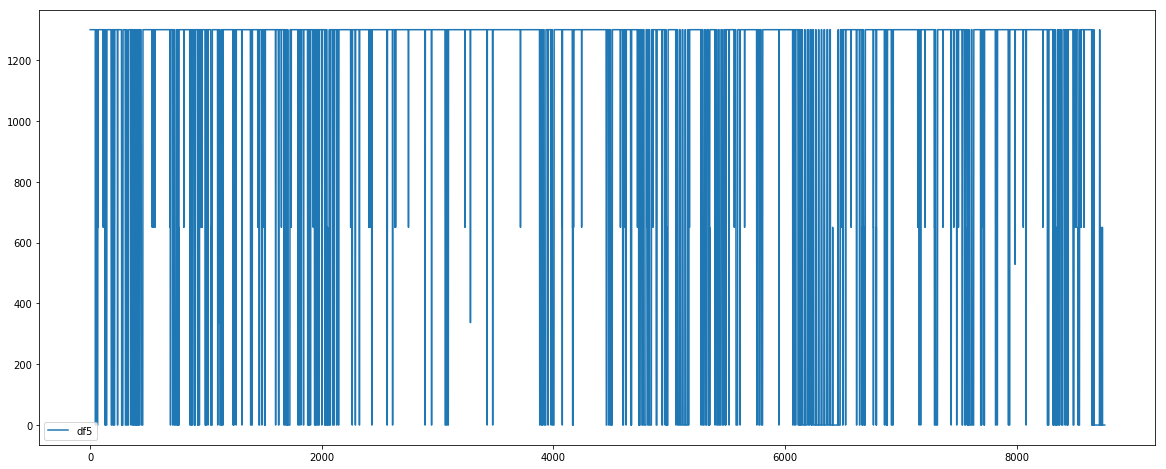

In [170]:
df1 = E_1_df.copy()
df2 = H2_tank_in_df.copy()
df3 = H2_tank_out_df.copy()
df4 = H2_direct_df.copy()
df5 = CO2_df.copy()

%matplotlib inline
import matplotlib.pyplot as plt
    
fig = plt.figure(figsize = [20,8])
ax = fig.add_subplot(111)
    
# plt.plot(df1['hour'],df1['value'],label='df1')
# plt.plot(df2['hour'],df2['value'],label='df2')
# plt.plot(df4['hour'],df4['value'],label='df4')
# plt.plot(input_df.index.values.tolist(),input_df['NG_demand(m^3)'])
plt.plot(df5['hour'],df5['value'],label='df5')

plt.legend()

## B. HENG Result

In [172]:
HENG_result_df = pd.read_csv('HENG_result.csv')

In [176]:
HENG_result_df[HENG_result_df['variable'].str.contains('em')]

,Unnamed: 0,variable,value
82564,82564,em_heng,5618638.10
82565,82565,em_ng,5837591.90
82566,82566,em_offset_max_1,218953.76


In [177]:
df = HENG_result_df


print("CAPEX is:",format(df.loc[df['variable'] == 'CAPEX_2','value'].tolist()[0],","))
print("OPEX is:",format(df.loc[df['variable'] == 'OPEX_2','value'].tolist()[0],","))
print("Number of electrolyzers is:",format(df.loc[df['variable'] == 'N_electrolyzer_2','value'].tolist()[0],","))
print("Number of prestorage compressor is:",format(df.loc[df['variable'] == 'N_prestorage','value'].tolist()[0],","))
print("Number of storage is:",format(df.loc[df['variable'] == 'N_tank','value'].tolist()[0],","))
print("Emission offset is:",format(df.loc[df['variable'] == 'em_offset_max_1','value'].tolist()[0],","))

CAPEX is: 54,304.462999999996
OPEX is: 7,705,231.8
Number of electrolyzers is: 125.0
Number of prestorage compressor is: 0.0
Number of storage is: 0.0
Emission offset is: 218,953.76


In [ ]:
df1 = E_1_df.copy()
df2 = H2_tank_in_df.copy()
df3 = H2_tank_out_df.copy()
df4 = H2_direct_df.copy()
df5 = CO2_df.copy()

%matplotlib inline
import matplotlib.pyplot as plt
    
fig = plt.figure(figsize = [20,8])
ax = fig.add_subplot(111)
    
# plt.plot(df1['hour'],df1['value'],label='df1')
# plt.plot(df2['hour'],df2['value'],label='df2')
# plt.plot(df4['hour'],df4['value'],label='df4')
# plt.plot(input_df.index.values.tolist(),input_df['NG_demand(m^3)'])
plt.plot(df5['hour'],df5['value'],label='df5')

plt.legend()

## C. Transportation Result

In [184]:
transportation_result_df = pd.read_csv('transportation_result.csv')

In [185]:
df = transportation_result_df


print("CAPEX is:",format(df.loc[df['variable'] == 'CAPEX_3','value'].tolist()[0],","))
print("OPEX is:",format(df.loc[df['variable'] == 'OPEX_3','value'].tolist()[0],","))
print("Number of electrolyzers is:",format(df.loc[df['variable'] == 'N_electrolyzer_3','value'].tolist()[0],","))
print("Number of booster compressor is:",format(df.loc[df['variable'] == 'N_booster_3','value'].tolist()[0],","))
print("Number of prestorage compressor is:",format(df.loc[df['variable'] == 'N_prestorage_3','value'].tolist()[0],","))
print("Number of storage is:",format(df.loc[df['variable'] == 'N_tank_3','value'].tolist()[0],","))
print("Emission offset is:",format(df.loc[df['variable'] == 'em_offset_3','value'].tolist()[0],","))

CAPEX is: 37,912,888,000.0
OPEX is: 56,373,647.0
Number of electrolyzers is: 2,609.0
Number of booster compressor is: 514.0
Number of prestorage compressor is: 1,451.0
Number of storage is: 60,467.0
Emission offset is: 433,855.84


In [186]:
df = transportation_result_df 

H2_3_df = create_var_df_from_result(df,'H2_3_',hour_str='Y')
I_3_df = create_var_df_from_result(df,'I_3_',hour_str='Y')
H2_tank_in_3_df = create_var_df_from_result(df,'H2_tank_in_3_',hour_str='Y')
H2_tank_out_3_df = create_var_df_from_result(df,'H2_tank_out_3_',hour_str='Y')
H2_direct_3_df = create_var_df_from_result(df,'H2_direct_3_',hour_str='Y')


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
8761,8761,H2_3_0,372797.42,0
8762,8762,H2_3_1,365382.51,1
9873,9873,H2_3_2,362416.55,2
10984,10984,H2_3_3,353518.67,3
12095,12095,H2_3_4,368348.48,4


The length of variable df:  0
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
26281,26281,H2_tank_in_3_0,341654.82,0
26282,26282,H2_tank_in_3_1,341654.82,1
27393,27393,H2_tank_in_3_2,341654.82,2
28504,28504,H2_tank_in_3_3,341654.82,3
29615,29615,H2_tank_in_3_4,341654.82,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
35041,35041,H2_tank_out_3_0,0.0,0
35042,35042,H2_tank_out_3_1,0.0,1
36153,36153,H2_tank_out_3_2,0.0,2
37264,37264,H2_tank_out_3_3,0.0,3
38375,38375,H2_tank_out_3_4,0.0,4


The length of variable df:  8760
The first 5 hours of the data:


,Unnamed: 0,variable,value,hour
17521,17521,H2_direct_3_0,31142.603,0
17522,17522,H2_direct_3_1,23727.697,1
18633,18633,H2_direct_3_2,20761.735,2
19744,19744,H2_direct_3_3,11863.849,3
20855,20855,H2_direct_3_4,26693.660,4


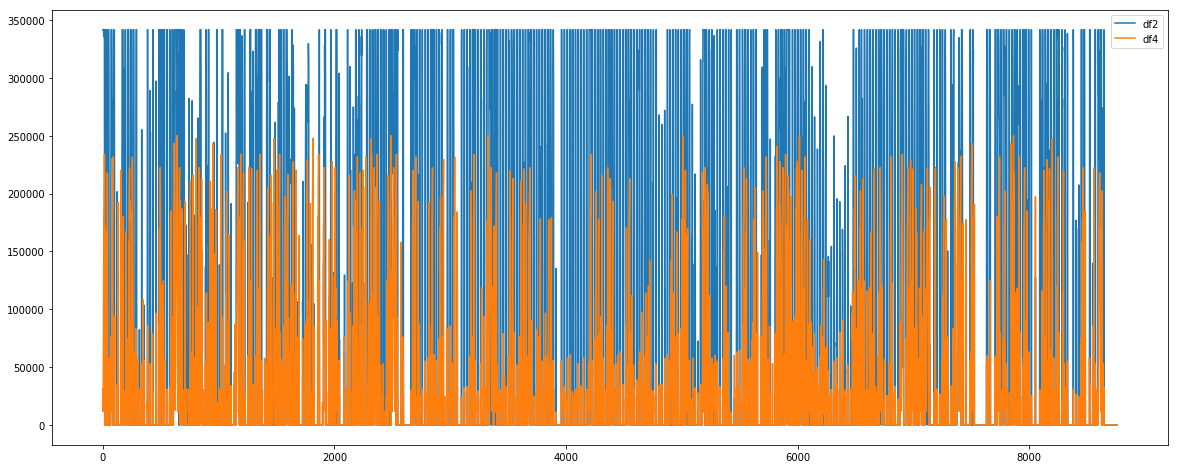

In [187]:
df1 = H2_3_df
df2 = H2_tank_in_3_df
df3 = H2_tank_out_3_df
df4 = H2_direct_3_df
    
%matplotlib inline
import matplotlib.pyplot as plt
    
fig = plt.figure(figsize = [20,8])
ax = fig.add_subplot(111)
    
# plt.plot(df1['hour'],df1['value'],label='df1')
plt.plot(df2['hour'],df2['value'],label='df2')
# plt.plot(df3['hour'],df3['value'],label='df3')
plt.plot(df4['hour'],df4['value'],label='df4')

plt.legend()

## D. Industry Result

## E. Combined Result

In [178]:
combined_result_df = pd.read_csv('combined_result.csv')

In [179]:
combined_result_df.head()

,Unnamed: 0,variable,value
0,0,CAPEX_Electrolyzer,3.420365e+05
1,1,CAPEX_booster_comp,3.841422e+08
2,2,CAPEX_reactor,0.000000e+00
3,3,CAPEX_storage,3.535226e+10
4,4,CO2_0,0.000000e+00


In [183]:
combined_result_df[combined_result_df['variable'].str.contains('OPEX')]

,Unnamed: 0,variable,value
96368,96368,OPEX_SBG,170208690.0
96369,96369,OPEX_booster_comp,9515260.9
96370,96370,OPEX_reactor,0.0


In [ ]:
combined_result_df[combined_result_df['variable'].str.contains('em')]

df = combined_result_df


print("CAPEX is:",format(df.loc[df['variable'] == 'CAPEX_2','value'].tolist()[0],","))
print("OPEX is:",format(df.loc[df['variable'] == 'OPEX_2','value'].tolist()[0],","))
print("Number of electrolyzers is:",format(df.loc[df['variable'] == 'N_electrolyzer_2','value'].tolist()[0],","))
print("Number of prestorage compressor is:",format(df.loc[df['variable'] == 'N_prestorage','value'].tolist()[0],","))
print("Number of storage is:",format(df.loc[df['variable'] == 'N_tank','value'].tolist()[0],","))
print("Emission offset is:",format(df.loc[df['variable'] == 'em_offset_max_1','value'].tolist()[0],","))